# Playing around w/PIV data

*Connor Duffin - University of Cambridge*

In this notebook we mess about with Paul Branson's PIV data, getting a feel for what the data looks like. First we load in the requisite libraries:

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:
ds = xr.open_dataset("../data/CylinderTest02_G0_dt2.00_de0.50_ne4_velocity.nc")
ds

<xarray.Dataset>
Dimensions:  (time: 69, x: 64, y: 48, z: 45)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-13T12:31:42.727000 ... 2016-07-13T...
  * x        (x) float32 0.01056 0.01584 0.02112 0.0264 ... 0.3326 0.3379 0.3432
  * y        (y) float32 0.01056 0.01584 0.02112 0.0264 ... 0.2482 0.2534 0.2587
  * z        (z) float32 0.003 0.0045 0.006 0.0075 ... 0.0645 0.066 0.0675 0.069
Data variables:
    U        (time, x, y, z) float32 ...
    V        (time, x, y, z) float32 ...
    W        (time, x, y, z) float32 ...
Attributes: (12/24)
    XML:                     <config>\n\t<runFolder>/scratch/pawsey0106/pbran...
    captureDt:               0.05
    capture_burst_interval:  1.0
    capture_n_burst:         11
    dx:                      0.005280000157654285
    dy:                      0.005280000157654285
    ...                      ...
    run_id:                  CylinderTest02
    source:                  3DPIV applied to Synthetic Aperture Imagery
    title:                   Three dimensional particle imaging velocimetry data
    velocityError:           0.8184353113174438
    vorticityError:          0.15431763231754303
    license:                 https://creativecommons.org/licenses/by/4.0/lega...

In [17]:
(ds.time[-1] - ds.time[0]) * 1e-9

<xarray.DataArray 'time' ()>
array(136, dtype='timedelta64[ns]')

This dataset has fully resolved, 3D measurements of all three velocity components. There are 69 total measurement times and at each of these times we observe $64 \times 48 \times 45$ locations across the $(x, y, z)$ domain. At each location we observe the velocity field, which consists of the three components $(u, v, w)$ (horizontal, vertical, upward). So this is a pretty amazing dataset!

First we take a slice of the data, at the vertical midpoint of the domain:

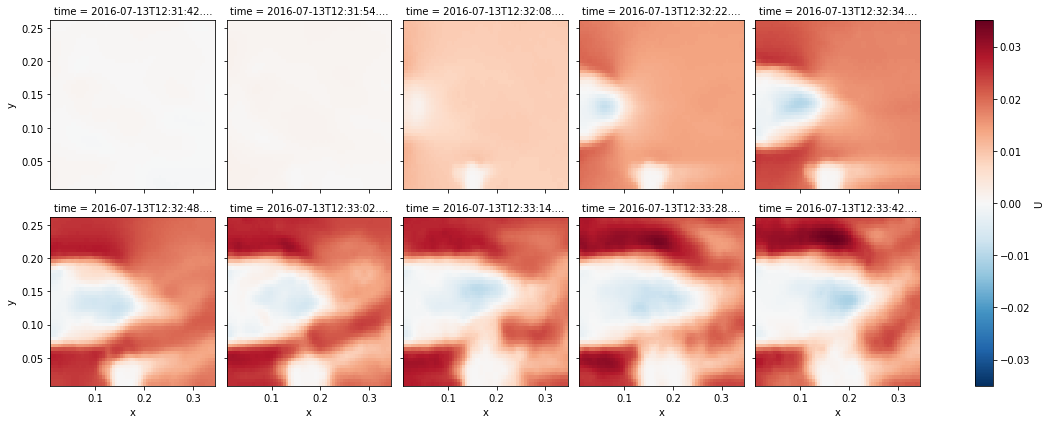

In [48]:
u_averaged = np.mean(ds.U, axis=-1)
v_averaged = np.mean(ds.V, axis=-1)
w_averaged = np.mean(ds.W, axis=-1)

u_averaged.isel(
    time=(np.linspace(0, 60, 10, dtype=np.int32))).plot(x="x", y="y", col="time", col_wrap=5)
plt.show()

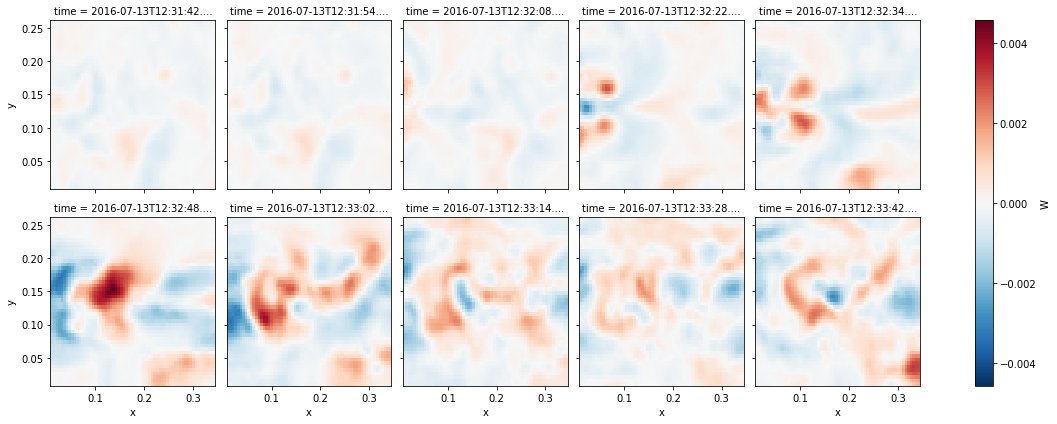

In [49]:
w_averaged.isel(
    time=(np.linspace(0, 60, 10, dtype=np.int32))).plot(x="x", y="y", col="time", col_wrap=5)
plt.show()

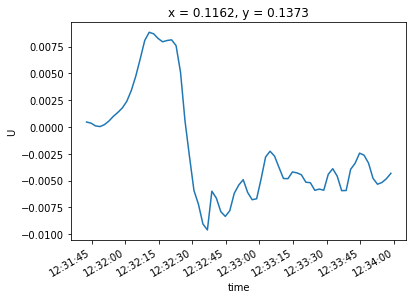

In [52]:
u_averaged.isel(x=20, y=24).plot()
plt.show()

In [4]:
z_slice_index = 22
u_slice, v_slice, w_slice = (ds.U[:, :, :, z_slice_index], 
                             ds.V[:, :, :, z_slice_index], 
                             ds.W[:, :, :, z_slice_index])
vel_magnitude = np.sqrt(u_slice**2 + v_slice**2)

And we plot an animation of the horizontal velocity field, across this slice:

In [5]:
%matplotlib notebook

vmin, vmax = np.amin(u_slice.as_numpy()), np.amax(u_slice.as_numpy())

figu = plt.figure()
axu = figu.add_subplot(1, 1, 1)
xr.plot.pcolormesh(u_slice[0, :, :], "x", "y", 
                   ax=axu, add_colorbar=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)

def animate(i):
    return xr.plot.pcolormesh(u_slice[i, :, :], "x", "y", 
                              ax=axu, add_colorbar=False, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    
u_ani = FuncAnimation(figu, animate, frames=len(ds.time))
plt.show()

<IPython.core.display.Javascript object>

We can also do the same for the vertical upwelling:

In [6]:
vmin, vmax = np.amin(w_slice.as_numpy()), np.amax(w_slice.as_numpy())

figu = plt.figure()
axu = figu.add_subplot(1, 1, 1)
xr.plot.pcolormesh(w_slice[0, :, :], "x", "y", 
                   ax=axu, add_colorbar=True, cmap="RdBu_r", vmin=vmin, vmax=vmax)

def animate(i):
    return xr.plot.pcolormesh(w_slice[i, :, :], "x", "y", 
                              ax=axu, add_colorbar=False, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    
u_ani = FuncAnimation(figu, animate, frames=len(ds.time))
plt.show()

<IPython.core.display.Javascript object>

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


Notice that in this case there is not too much vertical movement of the fluid: the magnitude of the velocities is quite small in comparison to the horizontal velocities.

## Proper orthogonal decomposition (POD)

Now we conduct a POD analysis of the velocity in the $y$ direction, using the vertical slice that we looked at above. The POD is a dimensionality reduction technique that essentiall computes an eigendecomposition of the velocity "covariance matrix".

The POD is derived, in a heuristic manner, as follows. Suppose that we have a velocity field $v(x, t)$, and we want to decompose this in to a sum of the form

\begin{equation}
  v(x, t) = \sum_{j = 1}^\infty \lambda_j(t) \phi_j(x)
\end{equation}

and these $\{\phi_j(x)\}_{j = 1}^\infty$ are assumed to be orthonormal with respect to the $L^2$ inner product. Then supposing that we have observed a set of measurements of this velocity field,

\begin{equation}
  D = \begin{bmatrix}
    v(x_1, t_1) & \ldots & v(x_1, t_m) \\
    \vdots & \ddots & \vdots \\
    v(x_n, t_1) & \ldots & v(x_n, t_m) \\
  \end{bmatrix},
\end{equation}

so that $D \in \mathbb{R}^{n \times m}$ ($m < n$). This is a "tall and skinny" matrix, and can be decomposed via the SVD to give:

\begin{equation}
  D = U \Sigma V^\top
\end{equation}

Now $U$ has orthonormal columns, $U = [u_1, \ldots, u_m]$, which form a pseudo-basis on $\mathbb{R}^n$. These connect to $\phi_j(x)$ via the relation $\phi_j(x_i) = U_{ij}$. So $[u_1, \ldots, u_m]$ are modes of the decomposition and are the finite-dimensional approximations to the orthonormal $\phi_j$.

To compute the coefficients $\lambda_j$ in the infinite dimensional case we dot these with $v$ to pull them out of the sum:

\begin{equation}
  \langle v(x, t), \phi_j(x) \rangle = \lambda_j(t).
\end{equation}

A finite dimensional approximation replaces the $L^2$ inner product with the Euclidean inner product, so that

\begin{equation}
  D^\top u_j = A_j,
\end{equation}

and $A_{ji} = \lambda_j(t_i)$. Thus the $A$ matrix rows are the temporally varying coefficients of each of the modes. Note that this is just projecting the data matrix $D$ onto the pseudo-basis given by the column space of $U$.

For higher spatial dimensions, this can be done through stacking the spatial dimensions across the rows of $D$. I.e. if we have $n_t$ measurements at $(n_x \times n_y)$ locations, then we simply form the $(n_t \times n_x n_y)$ matrix $D$.

In [7]:
nt, nx, ny = v_slice.shape
v_stacked = v_slice.stack(s=("x", "y"))
v_mean = np.mean(v_stacked, axis=0)
v_centered = v_stacked - v_mean
v_centered

<xarray.DataArray 'V' (time: 69, s: 3072)>
array([[ 1.9046117e-04,  7.2855561e-05, -7.2096562e-05, ...,
         1.3295023e-03,  1.2788788e-03,  1.2016261e-03],
       [ 1.8168613e-04,  5.8928650e-05, -1.0531573e-04, ...,
         1.2889972e-03,  1.2525272e-03,  1.2427798e-03],
       [ 1.6558787e-04,  8.2546816e-05, -8.0339465e-05, ...,
         1.2823702e-03,  1.2318868e-03,  1.1810473e-03],
       ...,
       [-1.0353171e-03, -1.0507625e-03, -1.0849189e-03, ...,
        -6.5169611e-04, -6.3121831e-04, -6.0363673e-04],
       [-1.1400507e-03, -1.1766969e-03, -1.2334547e-03, ...,
         9.7249745e-04, -3.3291907e-04, -7.0043164e-04],
       [-7.4505934e-04, -7.7514444e-04, -8.8345050e-04, ...,
        -1.2132839e-03, -4.2766950e-04, -1.3294502e-04]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-13T12:31:42.727000 ... 2016-07-13T...
    z        float32 0.036
  * s        (s) object MultiIndex
  * x        (s) float32 0.01056 0.01056 0.01056 ... 0.3432 0.3432 0.3432
  * y        (s) float32 0.01056 0.01584 0.02112 0.0264 ... 0.2482 0.2534 0.2587

In [8]:
v_svd = np.linalg.svd(v_centered.T, full_matrices=False)
modes_raw, vals = v_svd[0], v_svd[1]**2
print(modes_raw.shape)

(3072, 69)


First we plot the eigenvalues:

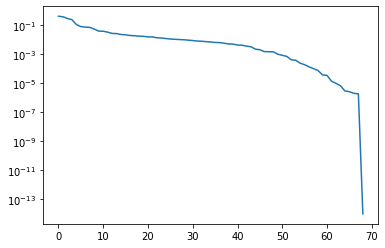

In [9]:
%matplotlib inline
plt.semilogy(vals)
plt.show()

And pull apart the modes:

In [10]:
modes = v_centered.copy()
modes[:, :] = modes_raw.T
modes = modes.unstack("s")
modes = modes.to_dataset()
modes

<xarray.Dataset>
Dimensions:  (x: 64, y: 48, time: 69)
Coordinates:
  * x        (x) float32 0.01056 0.01584 0.02112 0.0264 ... 0.3326 0.3379 0.3432
  * y        (y) float32 0.01056 0.01584 0.02112 0.0264 ... 0.2482 0.2534 0.2587
  * time     (time) datetime64[ns] 2016-07-13T12:31:42.727000 ... 2016-07-13T...
    z        float32 0.036
Data variables:
    V        (time, x, y) float32 -0.005447 -0.005213 ... 0.008327 -0.0148

Then we plot the modes:

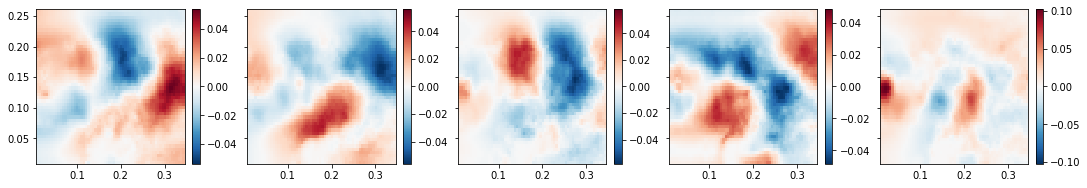

In [11]:
n_plot = 5
fig, axs = plt.subplots(1, n_plot, sharex=True, sharey=True, constrained_layout=True, figsize=(15, 2.5))

for i in range(n_plot):
    xr.plot.pcolormesh(modes.V[i, :, :], "x", "y", ax=axs[i], add_labels=False)
    
plt.show()

And finally the coefficients:

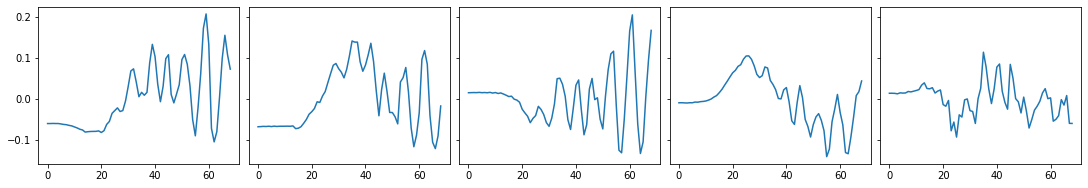

In [12]:
coefs = np.dot(v_centered, modes_raw)
fig, axs = plt.subplots(1, n_plot, sharex=True, sharey=True, constrained_layout=True, figsize=(15, 2.5))

for i in range(n_plot):
    axs[i].plot(coefs[:, i])
    
plt.show()